# Non Res PIR linear regression model

### Linear regression model to convert non res PIR people figures to Filled post estimates

In [1]:
import polars as pl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
import io
import boto3
import re
import os
from enum import Enum
from sklearn.base import BaseEstimator

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Read AWS Glue Schema

- Ideally we would use the defined ```schema_reader``` to read in the S3 schema - *due to case insensitivity in spark we cannot currenlty read the schema as the column names do not match the parquet file, this should be changed in the validation step*.
- Reading the schema will make the reading of the data *faster* and more *reliable*.

In [3]:
import sys
notebook_dir = os.getcwd()

project_root = os.path.dirname(notebook_dir)

sys.path.insert(0, project_root)

from utilities.version import ModelVersionManager

In [ ]:
# from utilities.schema_reader import GlueSchemaReader
# gsr = GlueSchemaReader("main-data-engineering-database")

In [ ]:
# plschema = gsr.get_polars_schema("dataset_ind_cqc_estimated_missing_ascwds_filled_posts")
# df1 = pl.scan_parquet(DATA,schema=plschema)

# tried to pull schema but it does not agree with a parquet file, this should be changed in a validation step in order to read and use schema 

### Read data from S3

Specify the bucket and the source path of the initial data.

In [2]:
BUCKET = 'sfc-mt-sagemaker-demo'                                                                                    #used for demo purposes 
DATA = 's3://sfc-main-datasets/domain=ind_cqc_filled_posts/dataset=ind_cqc_estimated_missing_ascwds_filled_posts/'

- Instead of infering schema we will read the data from S3 without the schema asigned for now.
- When reading the data with ```scan_parquet``` it reads it as a [LazyFrame](https://docs.pola.rs/api/python/stable/reference/lazyframe/index.html) which you can filter.
- Ahead of using the data in a model you will need to ```collect()``` the data as shown further below. 

In [5]:
df1 = pl.scan_parquet(DATA)

Filtering dataset to required data using Polars syntax.

In [9]:
df1_selected = df1.select("locationId", "cqc_location_import_date", "careHome", "ascwds_filled_posts_deduplicated_clean" ,"pir_people_directly_employed_deduplicated")
df1_filtered = df1_selected.filter(pl.col("careHome") == "N")
df1_filtered2 = df1_filtered.filter(
    (pl.col("ascwds_filled_posts_deduplicated_clean").is_not_null()) 
    & (pl.col("ascwds_filled_posts_deduplicated_clean") > 0) 
    & (pl.col("pir_people_directly_employed_deduplicated").is_not_null())
    & (pl.col("pir_people_directly_employed_deduplicated") > 0)
)
df1_filtered3 = df1_filtered2.with_columns(
    (pl.col("ascwds_filled_posts_deduplicated_clean") - pl.col("pir_people_directly_employed_deduplicated")).abs().alias("abs_resid"))

# Due to the case insensitivity the column titles when scanned appear like 'locationId' instead of 'locationid'

Test Dataset matches example model 

In [ ]:
# Test a date for 28,000 rows 
dftest = df1.filter(pl.col("import_date") == 20250301)
dftest.collect().shape 

In [ ]:
df1_filtered3.sort(pl.col("abs_resid"), descending=True).collect().head(10)

# shows same data and EMR noteboook

Create filtered and excluded datasets

In [10]:
filtered_df = df1_filtered3.filter(pl.col("abs_resid") <= 500).drop("abs_resid")
excluded_df = df1_filtered3.filter(pl.col("abs_resid") > 500).drop("abs_resid")

Previously when the models were in EMR, Pyspark required vectorising of the data for modelling. 
This is not required for Polars

As the dataset is a small enough this is not required in scikitlearn ahead of linear regression but if needed for more complicated models in the future Please seee below the syntax required. 

In [ ]:
# vectorised_features_df = DictVectorizer()     Does what the VectorAssembler() did in pyspark - required for pyspark model 

## Separate into training and test sets

In [11]:
TRAIN_FRAC = 0.8
df_eager = filtered_df.collect()                                                          #this converts the lazyframe to a dataframe (this is needed for the modeling)
df_train1 = df_eager.sample(fraction=TRAIN_FRAC, with_replacement=False, shuffle=True, seed=55)
df_test1 = df_eager.join(df_train1, on=df_eager.columns, how='anti')

# Go through and explain each part of the code and what it does 

## Training
1. Put the data into numpy arrays for use by scikit-learn
2. Create and fit the model
3. Get the predicted values from the model

In [12]:
x1 = df_train1['pir_people_directly_employed_deduplicated'].to_numpy().reshape(-1,1)   #input feature (Reshapes the 1D array into a 2D column vector, which is required by sklearn.)
y1 = df_train1['ascwds_filled_posts_deduplicated_clean'].to_numpy()                    #target variable
model1 = LinearRegression()
model1.fit(x1, y1)                                                                     #fits the linear regression model
y_pred1 = model1.predict(x1)                                                           #predicts filled posts based on people

Scikitlearn offers a wide range of [Linear models](https://scikit-learn.org/stable/modules/linear_model.html) that can be imported for more complicated models. 

An example of others you used in this simple model is [Polynomial Regression](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions).

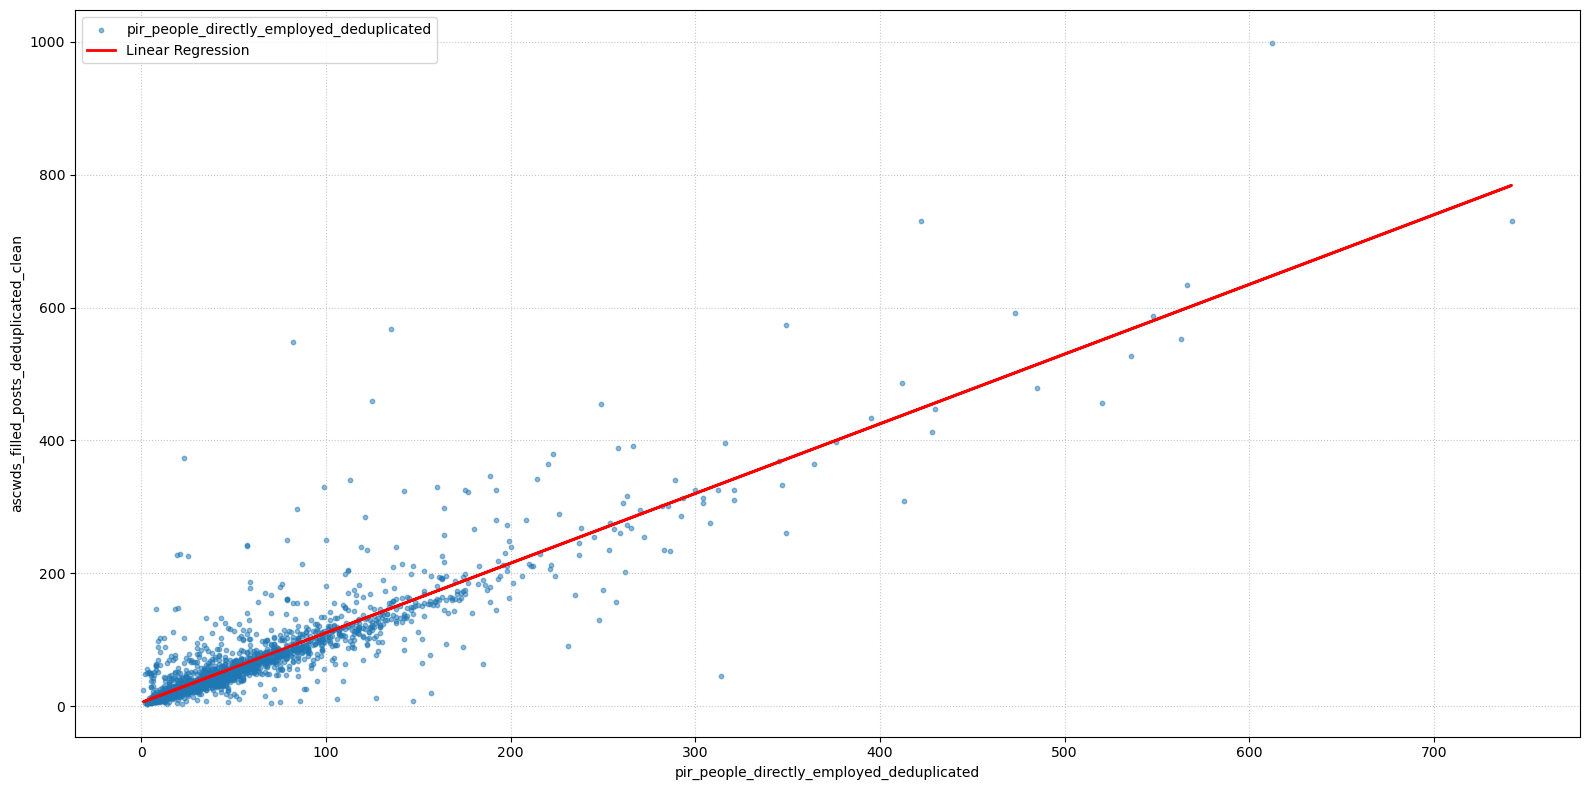

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(x1, y1, alpha=0.5, s=10, label='pir_people_directly_employed_deduplicated')
ax.plot(x1, y_pred1, color='red', linewidth=2, label='Linear Regression')
# ax.set_title('')
ax.set_xlabel('pir_people_directly_employed_deduplicated')
ax.set_ylabel('ascwds_filled_posts_deduplicated_clean')
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

# ask gary to take through each of the regressions he used - I can add this but not a priority 
# find list of each of these within 

### Verify that the R^{2} is good

Specify the bucket and the source path of the initial data.

In [14]:
r2_1 = r2_score(y1, y_pred1)

print(f'The model has an R2 score {r2_1}')

The model has an R2 score 0.7924079133306925


## Check model against test set

In [15]:
x_test1 = df_test1['pir_people_directly_employed_deduplicated'].to_numpy().reshape(-1,1)
y_test1 = df_test1['ascwds_filled_posts_deduplicated_clean'].to_numpy()
y_test_pred1 = model1.predict(x_test1)
r2_test1 = r2_score(y_test1, y_test_pred1)
print(f'The model scores {r2_test1} on test data')

The model scores 0.8296109362798311 on test data


Extract the model parameters if desired.

In [16]:
slope = model1.coef_[0]
intercept = model1.intercept_
print(f'The model slope is {slope}, and the intercept is {intercept}')

The model slope is 1.0486077809382155, and the intercept is 5.658492020285884


## Save the model to S3

For demo purposes we will delete anything in the Bucket to show a fresh save to the S3 bucket

In [17]:
s3 = boto3.client('s3')
try:
    s3.delete_object(Bucket='sfc-mt-sagemaker-demo', Key='params/v1/params.pkl')
    print("Deleted params/v1/params.pkl from sfc-mt-sagemaker-demo")
    s3.delete_object(Bucket='sfc-mt-sagemaker-demo', Key='params/v2/params.pkl')
    print("Deleted params/v2/params.pkl from sfc-mt-sagemaker-demo")
except Exception as e:
    print(e)
    print('Deletion failed, possibly no files')

Deleted params/v1/params.pkl from sfc-mt-sagemaker-demo
Deleted params/v2/params.pkl from sfc-mt-sagemaker-demo


We will serialise the model using the built-in [pickle](https://docs.python.org/3/library/pickle.html) module. For a simple linear model, it is possible just to save the model parameters in plain text, but it is better practice to save the full model instance for re-use.

The ModelVersionManager includes pickling of the data and buffering the data for saving to the intended S3 bucket 

In [ ]:
BUCKET = 'sfc-mt-sagemaker-demo'

param_store_name = 'models/test/v2/ice_cream'
vm = ModelVersionManager(BUCKET, 'params/v1/params.pkl', param_store_name)
vm.prompt_and_save(model1)

## New data

Now we imagine that some time has passed and new data is available. First the analyst reads in the model that has been saved to S3. Then s/he reads in the new data and compares it to the model predictions. If these turn out to be a poor fit, the training/testing/serialisation cycle is restarted.

## Retrieve the serialised model

In [ ]:
download = io.BytesIO()
s3.download_fileobj(BUCKET, 'params/v1/params.pkl', download)
download.seek(0)
loaded_model = pickle.load(download)
loaded_model.coef_[0], loaded_model.intercept_

## Retrieve the latest data

- Set out the new data location within the S3 bucket.
- Use ```scan_parquet()``` to pull the data in as a Lazyframe, ```collect()``` data to convert to eager dataframe in order to compare the model predicitons to the new data.
- Plot the data as required/ as above.
- Repeat Training, Testing and Serialisation.
- Save to S3 as new version. 

# Test Result of Polars vs Pyspark

Test that the model using Polars produces the same model (intercept and gradient) as Pyspark

### As within Non Res PIR linear regression model 

Using Polars:
- Test using whole dataset in order to compare.
- No randomness to the data used.

In [ ]:
TRAIN_FRAC_TEST = 1

df_eager1 = filtered_df.lazy().collect()
polars_test = df_eager1.sample(fraction=TRAIN_FRAC_TEST) # no need to input randomness in the dataset
df_test = df_eager1.join(polars_test, on=df_eager1.columns, how='anti')

In [ ]:
x1 = polars_test['pir_people_directly_employed_deduplicated'].to_numpy().reshape(-1,1)   #input feature (Reshapes the 1D array into a 2D column vector, which is required by sklearn.)
y1 = polars_test['ascwds_filled_posts_deduplicated_clean'].to_numpy()                    #target variable
modeltest = LinearRegression()
modeltest.fit(x1, y1)                                                                     #fits the linear regression model
y_predtest = modeltest.predict(x1)                                                        #predicts filled posts based on people

In [ ]:
slope = modeltest.coef_[0]
intercept = modeltest.intercept_
print(f'The model slope is {slope}, and the intercept is {intercept}')

Using PySpark:
- This has been carried out within EMR to test and save this result.
- This is because EMR supports Pyspark as spark needs clusters.
- Again, test using the whole dataset in order to be able to compare.
- No Randomness to the dataset.